**Imagining that I work for Nationwide Insurance, I came up with a simple concept that probably expands a concept thats already in place. The idea of this analysis is one of many ways to "rate" a customer's likelihood of being involved in an accident, or making a claim. This is referred to in my dataframe as 'RISK.'**

**When considering the likelihood of a customer making an insurance claim,
the customer's home and work locations are often considered. Drivers that live 
near areas where "risky" driving is more prevalent may have a greater
likelihood of causing an accident, or making an insurance claim.**

In [0]:
# importing our dependencies
import time
import folium
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from google.colab import files
sns.set()

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link_ohio = 'https://drive.google.com/open?id=1L9ZRQA27zk0uXkNHHaLmYO0G_MhO5Bwj'
myid_ohio = link_ohio.split('=')[1]
downloaded_ohio = drive.CreateFile({'id': myid_ohio}) 
downloaded_ohio.GetContentFile('frame_ohio.csv')

# READING IN THE ORIGINAL DATAFRAME
df_original = pd.read_csv('frame_ohio.csv', low_memory=False).drop_duplicates()
df_ohio = df_original.copy()


# Changing the DataFrames datatypes and other details
# We want striclty only to use traffic stops that are related to "Speeding"
df_ohio = df_ohio[
  (df_ohio.violation.isnull()==False) &
  (df_ohio.violation.str.lower().str.contains('speed'))]
df_ohio['date'] = pd.to_datetime(df_ohio.date)

df_ohio['time'] = pd.to_datetime(df_ohio.time).dt.hour
df_ohio['date'] = pd.to_datetime(df_ohio.date)
df_ohio['location'] = df_ohio.location.astype('category')
df_ohio['county_name'] = df_ohio.county_name.astype('category')


print('The size of our dataframe:')
print(df_ohio.shape)
print()


df_ohio.iloc[0]

The size of our dataframe:
(2225454, 24)



raw_row_number                                   3
date                           2010-01-01 00:00:00
time                                             0
location            INDIAN RIPPLE RD&TONAWANDA TRL
lat                                        39.6962
lng                                       -84.1019
county_name                          Greene County
subject_race                                 black
subject_sex                                   male
officer_id_hash                         1d6afeaa47
department_name          Ohio State Highway Patrol
type                                     vehicular
violation                 Speed (hwy/expwy/freewy)
arrest_made                                  False
warning_issued                                True
outcome                                    warning
contraband_found                               NaN
contraband_drugs                               NaN
search_conducted                             False
search_basis                   

In [0]:
frame_county_speed_stops = df_ohio.copy()
frame_county_speed_stops['county_stops'] = 0
for cn in list(set(frame_county_speed_stops.county_name.tolist())):
  framex = frame_county_speed_stops[frame_county_speed_stops.county_name==cn]
  framex.loc['county_stops'] = framex[framex.county_name==cn].shape[0]
  framex[framex.county_name==cn].loc['county_stops'] = framex[framex.county_name==cn].shape[0]
#   framex.county_stops


def function_risk(value):
  '''The average total number of traffic stops for a county 
  in our dataset is about 25,000. Any counties that 
  exist above the 80th percentile, and below the 20th percentile will be 
  regarded as high and low risk respectively.'''
  if value >= frame.quantile(.80).values[0]: value = 'high'
  elif value <= frame.quantile(.20).values[0]: value = 'low'
  else: value = 'normal'
  return value

frame = pd.DataFrame(
    df_ohio.copy().groupby('county_name').size().sort_values(ascending=False))
frame.reset_index()
frame.rename({0:'county_stops'},inplace=True,axis=1)
frame['risk'] = frame.county_stops.apply(function_risk)
frame.shape

average_stops_per_county = frame.county_stops.mean()
print('The total overall average number of Traffic Stops-per-County is:')
print(average_stops_per_county)
print()

print('Counting the number of OSHP Traffic Stops for speeding,')
print('there are the top and bottom 10 counties:')
print(df_ohio.county_name.value_counts().sort_values(ascending=False).head(10))
print()
print(df_ohio.county_name.value_counts().sort_values(ascending=False).tail(10))
print()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


The total overall average number of Traffic Stops-per-County is:
25270.363636363636

Counting the number of OSHP Traffic Stops for speeding,
there are the top and bottom 10 counties:
Franklin County     92698
Hamilton County     67338
Warren County       57081
Delaware County     55432
Madison County      48764
Licking County      47678
Fairfield County    46472
Clermont County     45480
Cuyahoga County     45435
Portage County      42868
Name: county_name, dtype: int64

Noble County        6480
Coshocton County    5794
Darke County        5091
Champaign County    4684
Perry County        4624
Carroll County      3305
Putnam County       2941
Holmes County       2629
Monroe County       2318
Morgan County        874
Name: county_name, dtype: int64



Visualizing the distribution of Traffic Stops-per-County

The distribution of RISK:
normal    52
low       18
high      18
Name: risk, dtype: int64


Average number of Traffic Stops for "Speeding": 25270.363636363636



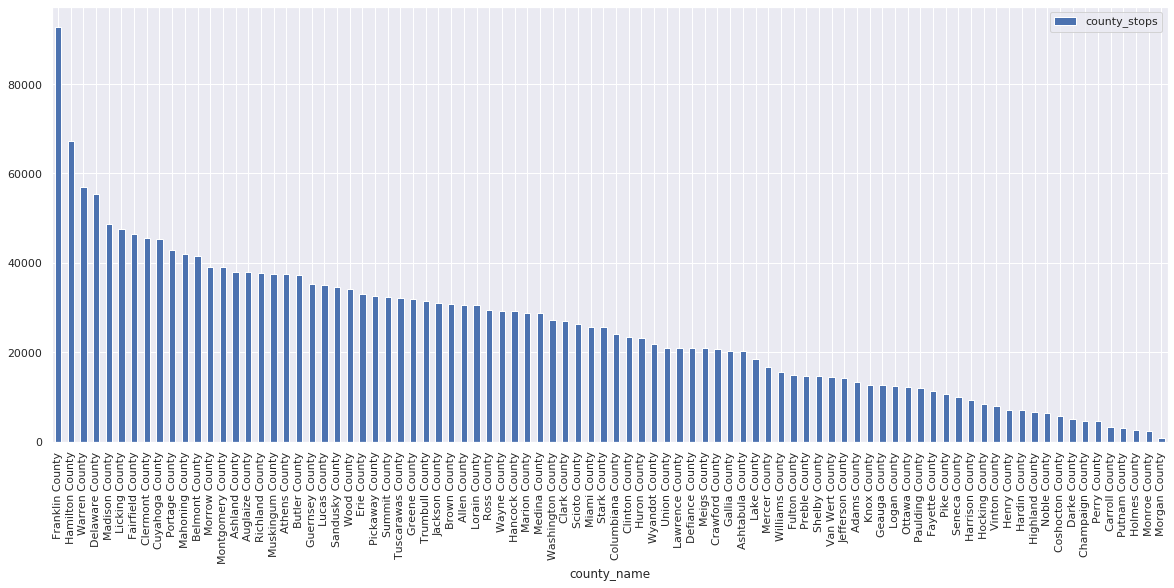

In [0]:
print('''Visualizing the distribution of Traffic Stops-per-County''')
print()

print('The distribution of RISK:')
print(frame.risk.value_counts())
print()

average_stops = frame.county_stops.mean()
print()
print('Average number of Traffic Stops for "Speeding": '+ str(average_stops))
print()
frame.plot(kind='bar',figsize=(20,8))

In [0]:
# Here I create several new dataframes, all representative of a different county of Ohio.
# Some of these counties have the highest amount of OSHP traffic stops
# in the entire state of Ohio overall.

df_franklin = df_ohio.copy()[df_ohio.county_name=='Franklin County']
df_hamilton = df_ohio.copy()[df_ohio.county_name=='Hamilton County']
df_cuyahoga = df_ohio.copy()[df_ohio.county_name=='Cuyahoga County']
df_mahoning = df_ohio.copy()[df_ohio.county_name=='Mahoning County']
df_lorain = df_ohio.copy()[df_ohio.county_name=='Lorain County']
list_frames = [df_franklin, df_hamilton, df_cuyahoga, df_mahoning, df_lorain]
list_todayframes = []

for df in list_frames:
  countyframe = df.copy()
  # for year in frame.date.dt.year.tolist():
  df_today = countyframe[
    (countyframe.date.dt.month==1) &
    (countyframe.date.dt.day==20)]
  list_todayframes.append(df_today)
  print()
  print(df_today.iloc[0].county_name)
  print('Total records for 1/20/20XX: ' + str(df_today.shape))


Franklin County
Total records for 1/20/20XX: (183, 24)

Hamilton County
Total records for 1/20/20XX: (129, 24)

Cuyahoga County
Total records for 1/20/20XX: (74, 24)

Mahoning County
Total records for 1/20/20XX: (98, 24)

Lorain County
Total records for 1/20/20XX: (66, 24)


In [47]:
def map_frame(dataframe):
  '''This function uses the Latitude and Longitude columns
  from a dataframe to plot location points on a map. This 
  will help in highlighting the differences between
  locations, and the trend of violations in each location.
  This function saves the map as a .html file to your
  normal download path.'''
  global map_osm

  print(dataframe.iloc[0].county_name)
  print(dataframe.location.value_counts().head(10))
  print()
  print(dataframe.time.value_counts().head(10))

  windowsize = folium.Figure(width=1000, height=600)
  map_osm = folium.Map(location=[dataframe.iloc[0].lat,dataframe.iloc[0].lng], 
      zoom_start=11, tiles="OpenStreetMap").add_to(windowsize)
  # x = plugins.MarkerCluster().add_to(map_osm)
  
  for index, rowdata in dataframe.iterrows():
      latitude = rowdata.lat
      longitude = rowdata.lng
      folium.Marker([latitude,longitude], popup='').add_to(map_osm)


# for frame in list_todayframes: map_frame(frame)
map_frame(list_todayframes[0])
map_osm  

from IPython.display import Image, display
link = 'https://live.staticflickr.com/65535/49416233656_54441901e8_b.jpg'
display(Image(url=link , width=800, height=500))

Franklin County
I270M33FRAR    14
I270M15FRAR    12
I270M30FRAR    11
I270M5FRAR     10
I270M31FRAR     7
I270M0FRAR      6
I270M1FRAR      6
I70M103FRAR     5
US23M3FRAR      5
I270M46FRAR     4
Name: location, dtype: int64

13    21
11    17
10    13
18    11
21    10
16    10
12     9
20     9
2      8
14     8
Name: time, dtype: int64
